In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings

import re
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Layer, Dense, Input, Activation, Embedding, SpatialDropout1D, Bidirectional, LSTM, GRU, GlobalMaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

In [3]:
class Attention(Layer):
    """
    Custom Keras attention layer
    Reference: https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
    """
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None, bias=True, **kwargs):

        self.supports_masking = True

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = None
        super(Attention, self).__init__(**kwargs)

        self.param_W = {
            'initializer': initializers.get('glorot_uniform'),
            'name': '{}_W'.format(self.name),
            'regularizer': regularizers.get(W_regularizer),
            'constraint': constraints.get(W_constraint)
        }
        self.W = None

        self.param_b = {
            'initializer': 'zero',
            'name': '{}_b'.format(self.name),
            'regularizer': regularizers.get(b_regularizer),
            'constraint': constraints.get(b_constraint)
        }
        self.b = None

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.features_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_shape[-1],),
                                 **self.param_W)

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     **self.param_b)

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        step_dim = self.step_dim
        features_dim = self.features_dim

        eij = K.reshape(
            K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))),
            (-1, step_dim))

        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [4]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def cleanup_text(msg):
    No_Punctuation = [char for char in msg if char not in string.punctuation]
    sentance = ''.join(No_Punctuation) #joins all the strings
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    return [word.lower() for word in sentance.split() if word.lower() not in stoplist_combined]


In [5]:
def hs_plot(history, name, eval):
    ''' history plot '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    ax[0].plot(epochs, loss, color='red', label='Training loss')
    ax[0].plot(epochs, val_loss, color='deeppink', label='Validation loss')
    ax[1].plot(epochs, accuracy, color='green', label='accuracy')
    ax[1].plot(epochs, val_accuracy, color='lime', label='val_accuracy')
    ax[0].set_title('Training and validation loss. {}, Eval: {}'.format(name, eval[0]))
    ax[1].set_title('Training and validation Metrics(Accuracy) {}, Eval: {}'.format(name, eval[1]))
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Metrics')
    ax[0].grid()
    ax[1].grid()
    ax[0].legend()
    ax[1].legend()
    plt.savefig('hist_{}.png'.format(name))
    plt.show()

In [6]:
%%time
max_length = 150
voc_size = 20000
embedding_dim = 32
warnings.simplefilter(action='ignore', category=FutureWarning)
os.chdir("/content/drive/MyDrive/Toxic")
data_dir = './Toxic_data'
traint_set1 = pd.read_csv(os.path.join(data_dir, 'jigsaw-toxic-comment-train.csv'), encoding="utf8", index_col='id')
traint_set2 = pd.read_csv(os.path.join(data_dir, 'jigsaw-unintended-bias-train.csv'), encoding="utf8", index_col='id')
valid_set = pd.read_csv(os.path.join(data_dir, 'validation.csv'), encoding="utf8", index_col='id')
traint_set2 = traint_set2[['comment_text',  'toxic', 'severe_toxicity',  'obscene',  'threat',  'insult',  'identity_attack']]
traint_set2 = traint_set2.rename(columns={'severe_toxicity': 'severe_toxic', 'identity_attack': 'identity_hate'})
train_set = pd.concat([traint_set1, traint_set2])
#print(train_set.shape)        #------------------------------------------!!!
#train_set = train_set[:1000]  #------------------------------------------!!!
#print(train_set.shape)         #------------------------------------------!!!

CPU times: user 13.6 s, sys: 1.62 s, total: 15.2 s
Wall time: 16 s


In [7]:
%%time
stopwords_set = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
nltk.download('stopwords') 
x = stopwords.words("english")
stopwords_nltk_en = set(x)
stoplist_combined = set.union(stopwords_set, stopwords_nltk_en)

# Text clean up
train_set['comment_text'] = train_set['comment_text'].apply(cleanup_text)
valid_set['comment_text'] = valid_set['comment_text'].apply(cleanup_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 10min 51s, sys: 27.8 s, total: 11min 19s
Wall time: 12min 49s


In [8]:
%%time
# remove '\\n'
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub('\\n', ' ', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub('\\n', ' ', str(x)))
# remove any text starting with User...
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub("\[\[User.*", '', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub("\[\[User.*", '', str(x)))
# remove IP addresses or user IDs
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", '', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", '', str(x)))
# remove http links in the text
train_set['comment_text'] = train_set['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)", '', str(x)))
valid_set['comment_text'] = valid_set['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)", '', str(x)))


CPU times: user 42.3 s, sys: 369 ms, total: 42.6 s
Wall time: 42.7 s


In [9]:
%%time
X = train_set.comment_text.to_numpy()
Y_tr = train_set.toxic.to_numpy()
#X, Y_tr = X[:10000], Y_tr[:10000] #----------------------------------------!!!
X_val = valid_set.comment_text.to_numpy()
Y_val = valid_set.toxic.to_numpy()
X_val, X_ts, Y_val, Y_ts = train_test_split(X_val, Y_val, test_size=0.5, random_state=1)
# pre-proc -------------
tokenizer = Tokenizer(num_words=voc_size, oov_token='<oov>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
X_seq = tokenizer.texts_to_sequences(X)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_tr = pad_sequences(X_seq, maxlen=max_length, padding='post', truncating='post')
X_ts_seq = tokenizer.texts_to_sequences(X_ts)
X_val = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_ts = pad_sequences(X_ts_seq, maxlen=max_length, padding='post', truncating='post')

CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 1min 46s


In [10]:
ep=3

Epoch 1/3
66430/66430 [==============================] - 2703s 41ms/step - loss: 0.2309 - accuracy: 0.7270 - val_loss: 0.6732 - val_accuracy: 0.8428
Epoch 2/3
66430/66430 [==============================] - 2698s 41ms/step - loss: 0.2249 - accuracy: 0.7276 - val_loss: 0.5346 - val_accuracy: 0.8432
Epoch 3/3
125/125 [==============================] - 2s 14ms/step - loss: 0.6532 - accuracy: 0.8510


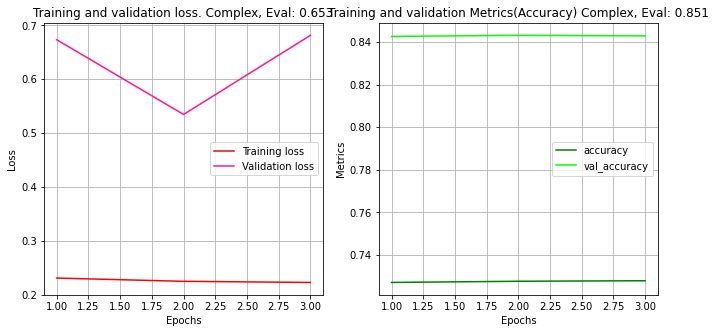

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: toxic_model_complex/assets


In [11]:
model_name = 'Complex'
inpt = Input(shape=(max_length,))
X = Embedding(voc_size, embedding_dim, input_length=max_length)(inpt)
X = Bidirectional(LSTM(256, return_sequences=True))(X)
X = Bidirectional(LSTM(128, return_sequences=True))(X)
att = Attention(max_length)(X)
avg_pool1 = GlobalAveragePooling1D()(X)
max_pool1 = GlobalMaxPooling1D()(X)
hidden = concatenate([att, avg_pool1, max_pool1])
hidden = Dense(512, activation='relu')(hidden)
hideen = Dense(128, activation='relu')(hidden)
outpt = Dense(1, activation='sigmoid')(hideen)
model = Model(inpt, outpt)
# compile-fit-evalueate
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_tr, Y_tr, epochs=ep, validation_data=(X_val, Y_val), verbose=1)
eval = np.round(model.evaluate(X_ts, Y_ts, verbose=1), 3)
hs_plot(history, model_name, eval)
model.save('toxic_model_complex')